In [1]:
# STEP2_pv_ev_multistep_lstm.py
# -------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, RepeatVector, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib

In [2]:
# ---------------------------
# Utility functions
# ---------------------------
def create_multistep_sequences(series_vals, seq_len=96, horizon=96):
    """Create X (seq_len) and y (horizon) windows from 1D series array."""
    X, y = [], []
    n = len(series_vals)
    for i in range(n - seq_len - horizon + 1):
        X.append(series_vals[i:i+seq_len])
        y.append(series_vals[i+seq_len:i+seq_len+horizon])
    X = np.array(X)
    y = np.array(y)
    return X, y

def build_seq2seq_model(seq_len, n_features, horizon, latent1=128, latent2=64, lr=5e-4):
    model = Sequential()
    model.add(Input(shape=(seq_len, n_features)))
    model.add(LSTM(latent1, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(RepeatVector(horizon))
    model.add(LSTM(latent2, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer=Adam(learning_rate=lr, clipnorm=1.0), loss='mse')
    return model

def evaluate_and_print(y_true, y_pred, label=""):
    # y_true/y_pred shape: (samples, horizon, 1) or (samples, horizon)
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    rmse = np.sqrt(mean_squared_error(yt, yp))
    mae = mean_absolute_error(yt, yp)
    # safe MAPE
    denom = np.where(np.abs(yt) < 1e-6, 1e-6, yt)
    mape = np.mean(np.abs((yt - yp) / denom)) * 100
    print(f"{label} RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.3f}%")
    return rmse, mae, mape

def plot_first_sample(y_true, y_pred, horizon, title=""):
    # plot first sample predicted vs actual for horizon
    plt.figure(figsize=(10,4))
    plt.plot(np.arange(horizon), y_true[0].reshape(-1), label="Actual")
    plt.plot(np.arange(horizon), y_pred[0].reshape(-1), label="Predicted")
    plt.xlabel("Timestep (15-min steps)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
# ---------------------------
# Settings
# ---------------------------
SEQ_LEN = 96      # 24 hours * 4 (15-min)
HORIZON = 96      # predict next 24 hours
TRAIN_RATIO = 0.7
EPOCHS = 40
BATCH = 64

out_dir = r"C:\Users\Administrator\v2g\step2_models"
os.makedirs(out_dir, exist_ok=True)

# PV (solar_irradiance) forecasting

In [4]:
# ---------------------------
# A) PV (solar_irradiance) forecasting
# ---------------------------
solar_csv = r"C:\Users\Administrator\v2g\clean_solar_data_15min.csv"
solar_df = pd.read_csv(solar_csv, parse_dates=["DATE"], index_col="DATE")
solar_df.index.name = "datetime"
print("Solar range:", solar_df.index.min(), "→", solar_df.index.max())

# Basic cleaning
solar_df["solar_irradiance"] = pd.to_numeric(solar_df["solar_irradiance"], errors="coerce")
solar_df = solar_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["solar_irradiance"])
# optional clip to remove extreme outliers
low, high = solar_df["solar_irradiance"].quantile([0.005, 0.995])
solar_df["solar_irradiance"] = solar_df["solar_irradiance"].clip(low, high)

Solar range: 2025-01-01 00:00:00 → 2025-11-24 00:00:00


In [5]:
# Use temperature as additional feature if present
features_pv = ["solar_irradiance"]
if "temp_c" in solar_df.columns:
    solar_df["temp_c"] = pd.to_numeric(solar_df["temp_c"], errors="coerce")
    solar_df = solar_df.dropna(subset=["temp_c"], how='any')
    features_pv.append("temp_c")

In [6]:
# Scale inputs and target
pv_input_scaler = MinMaxScaler()
pv_target_scaler = MinMaxScaler()

In [7]:
# We'll form multivariate inputs if temp present, else single
pv_inputs = pv_input_scaler.fit_transform(solar_df[features_pv])
pv_target = pv_target_scaler.fit_transform(solar_df[["solar_irradiance"]])

# If multiple input features, create sequences on inputs and use target for y windows
if pv_inputs.ndim == 1:
    pv_inputs = pv_inputs.reshape(-1,1)

In [8]:
# For simplicity use only the solar_irradiance series as target; we can also use multivariate X.
# Create sequences where X is multivariate (seq_len, n_features) and y is (horizon, 1)
# We'll use pv_inputs (multivariate) as X and pv_target.flatten() as target series for y windows
pv_X_nums, pv_y_nums = create_multistep_sequences(pv_inputs, seq_len=SEQ_LEN, horizon=HORIZON)
# pv_y should be from the target series:
target_series = pv_target.flatten()
_, pv_y = create_multistep_sequences(target_series, seq_len=SEQ_LEN, horizon=HORIZON)

In [9]:
print("PV shapes X,y:", pv_X_nums.shape, pv_y.shape)  # X: (samples, seq_len, n_features), y: (samples, horizon)

PV shapes X,y: (31202, 96, 2) (31202, 96)


In [10]:
# Train/test split
n_pv = len(pv_X_nums)
split_i = int(n_pv * TRAIN_RATIO)
X_pv_train, X_pv_test = pv_X_nums[:split_i], pv_X_nums[split_i:]
y_pv_train, y_pv_test = pv_y[:split_i], pv_y[split_i:]

In [11]:
# Build model
n_features_pv = X_pv_train.shape[2]
pv_model = build_seq2seq_model(seq_len=SEQ_LEN, n_features=n_features_pv, horizon=HORIZON, latent1=128, latent2=64, lr=5e-4)
pv_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 96, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 96, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,545 (455.25 KB)

 Trainable params: 116,545 (455.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Callbacks
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_pv = pv_model.fit(X_pv_train, y_pv_train.reshape((-1, HORIZON, 1)),
                          validation_split=0.1, epochs=EPOCHS, batch_size=BATCH,
                          callbacks=[es, rlp], verbose=1)

Epoch 1/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - loss: 0.0268 - val_loss: 2.9165e-04 - learning_rate: 5.0000e-04
Epoch 2/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.0042 - val_loss: 4.1258e-05 - learning_rate: 5.0000e-04
Epoch 3/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 43s 140ms/step - loss: 0.0038 - val_loss: 3.6407e-05 - learning_rate: 5.0000e-04
Epoch 4/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 44s 143ms/step - loss: 0.0036 - val_loss: 1.3957e-06 - learning_rate: 5.0000e-04
Epoch 5/40
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0035
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
308/308 ━━━━━━━━━━━━━━━━━━━━ 45s 148ms/step - loss: 0.0035 - val_loss: 5.2701e-06 - learning_rate: 5.0000e-04
Epoch 6/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - loss: 0.0033 - val_loss: 4.3937e-06 - learning_rate: 2.5000e-04
Epoch 7/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - loss: 0.0032 - val_loss: 1.5567e-05 - learning_rate: 2.5000e-04
Epoch 8/40
307/308 

In [13]:
# Predict and inverse transform
y_pv_pred_scaled = pv_model.predict(X_pv_test)
# y_pv_test_scaled = y_pv_test  # already scaled
# Inverse transform per-timestep
y_pv_pred = pv_target_scaler.inverse_transform(y_pv_pred_scaled.reshape(-1,1)).reshape(-1, HORIZON)
y_pv_test_real = pv_target_scaler.inverse_transform(y_pv_test.reshape(-1,1)).reshape(-1, HORIZON)

293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


PV (solar_irradiance) RMSE: 163.906614, MAE: 39.128028, MAPE: 186.950%


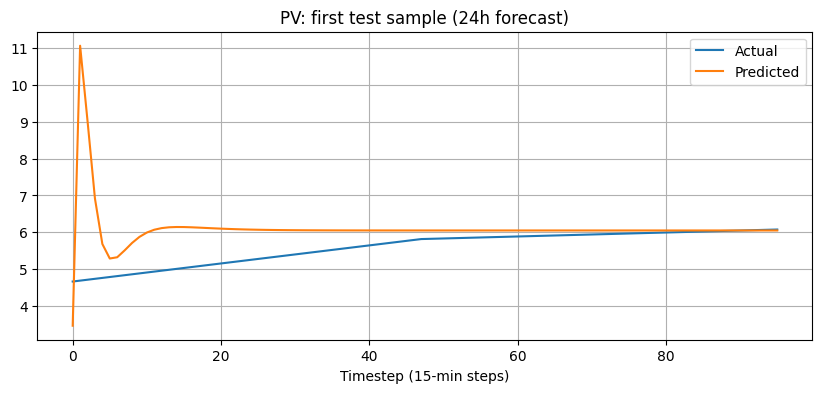

In [14]:
# Evaluate
evaluate_and_print(y_pv_test_real, y_pv_pred, label="PV (solar_irradiance)")
plot_first_sample(y_pv_test_real, y_pv_pred, HORIZON, title="PV: first test sample (24h forecast)")

In [15]:
# Save model and scalers
pv_model.save(os.path.join(out_dir, "pv_seq2seq_model.h5"))
joblib.dump(pv_input_scaler, os.path.join(out_dir, "pv_input_scaler.gz"))
joblib.dump(pv_target_scaler, os.path.join(out_dir, "pv_target_scaler.gz"))

['C:\\Users\\Administrator\\v2g\\step2_models\\pv_target_scaler.gz']

EV availability forecasting (ev_count)

In [16]:
# ---------------------------
# B) EV availability forecasting (ev_count)
# ---------------------------
ev_csv = r"C:\Users\Administrator\v2g\clean_ev_data_15min.csv"
ev_df = pd.read_csv(ev_csv, index_col=0, parse_dates=True)
print("EV range:", ev_df.index.min(), "→", ev_df.index.max())

EV range: 2020-01-01 18:15:00 → 2021-09-14 02:00:00


In [17]:
# derive ev_count (1 if kWhDelivered > 0 else 0). If kWhDelivered not present, use power_kw
if "kWhDelivered" in ev_df.columns:
    ev_df["ev_count"] = (pd.to_numeric(ev_df["kWhDelivered"], errors="coerce") > 0).astype(int)
elif "power_kw" in ev_df.columns:
    ev_df["ev_count"] = (pd.to_numeric(ev_df["power_kw"], errors="coerce") > 0).astype(int)
else:
    raise ValueError("EV file lacks kWhDelivered and power_kw columns.")

In [18]:
# clean
ev_df = ev_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ev_count"])

In [19]:
# optionally include power_kw or energy as features
features_ev = ["ev_count"]
if "power_kw" in ev_df.columns:
    ev_df["power_kw"] = pd.to_numeric(ev_df["power_kw"], errors="coerce").fillna(0)
    features_ev = ["power_kw"]  # we'll use power as input and ev_count as target (you can change)

In [20]:
# Scale inputs and target
ev_input_scaler = MinMaxScaler()
ev_target_scaler = MinMaxScaler()

ev_inputs = ev_input_scaler.fit_transform(ev_df[features_ev])
ev_target = ev_target_scaler.fit_transform(ev_df[["ev_count"]])

In [21]:
# Create sequences: use ev_inputs as X, ev_target series for y windows
ev_X_nums, _ = create_multistep_sequences(ev_inputs, seq_len=SEQ_LEN, horizon=HORIZON)
target_series_ev = ev_target.flatten()
_, ev_y = create_multistep_sequences(target_series_ev, seq_len=SEQ_LEN, horizon=HORIZON)

print("EV shapes X,y:", ev_X_nums.shape, ev_y.shape)

EV shapes X,y: (59457, 96, 1) (59457, 96)


In [22]:
# Create sequences: use ev_inputs as X, ev_target series for y windows
ev_X_nums, _ = create_multistep_sequences(ev_inputs, seq_len=SEQ_LEN, horizon=HORIZON)
target_series_ev = ev_target.flatten()
_, ev_y = create_multistep_sequences(target_series_ev, seq_len=SEQ_LEN, horizon=HORIZON)

print("EV shapes X,y:", ev_X_nums.shape, ev_y.shape)

EV shapes X,y: (59457, 96, 1) (59457, 96)


In [23]:
# Split train/test
n_ev = len(ev_X_nums)
split_i = int(n_ev * TRAIN_RATIO)
X_ev_train, X_ev_test = ev_X_nums[:split_i], ev_X_nums[split_i:]
y_ev_train, y_ev_test = ev_y[:split_i], ev_y[split_i:]

In [24]:
# Build model (single feature input maybe)
n_features_ev = X_ev_train.shape[2]
ev_model = build_seq2seq_model(seq_len=SEQ_LEN, n_features=n_features_ev, horizon=HORIZON, latent1=128, latent2=64, lr=5e-4)
ev_model.summary()

history_ev = ev_model.fit(X_ev_train, y_ev_train.reshape((-1, HORIZON, 1)),
                          validation_split=0.1, epochs=EPOCHS, batch_size=BATCH,
                          callbacks=[es, rlp], verbose=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 96, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 96, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 96, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
586/586 ━━━━━━━━━━━━━━━━━━━━ 96s 152ms/step - loss: 1.2155e-06 - val_loss: 1.6496e-09 - learning_rate: 5.0000e-04
Epoch 2/40
586/586 ━━━━━━━━━━━━━━━━━━━━ 89s 152ms/step - loss: 9.0952e-08 - val_loss: 7.5154e-09 - learning_rate: 5.0000e-04
Epoch 3/40
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 5.6073e-08
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
586/586 ━━━━━━━━━━━━━━━━━━━━ 90s 153ms/step - loss: 5.0681e-08 - val_loss: 6.4557e-09 - learning_rate: 5.0000e-04
Epoch 4/40
586/586 ━━━━━━━━━━━━━━━━━━━━ 91s 155ms/step - loss: 3.5682e-08 - val_loss: 1.6019e-10 - learning_rate: 2.5000e-04
Epoch 5/40
586/586 ━━━━━━━━━━━━━━━━━━━━ 92s 157ms/step - loss: 2.8914e-08 - val_loss: 7.5724e-11 - learning_rate: 2.5000e-04
Epoch 6/40
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2.5120e-08
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
586/586 ━━━━━━━━━━━━━━━━━━━━ 92s 156ms/step - loss: 2.3730e-08 - val_loss: 1.2384e-09 - 

558/558 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step
EV (ev_count) - treated as numeric RMSE: 0.000013, MAE: 0.000006, MAPE: 0.001%


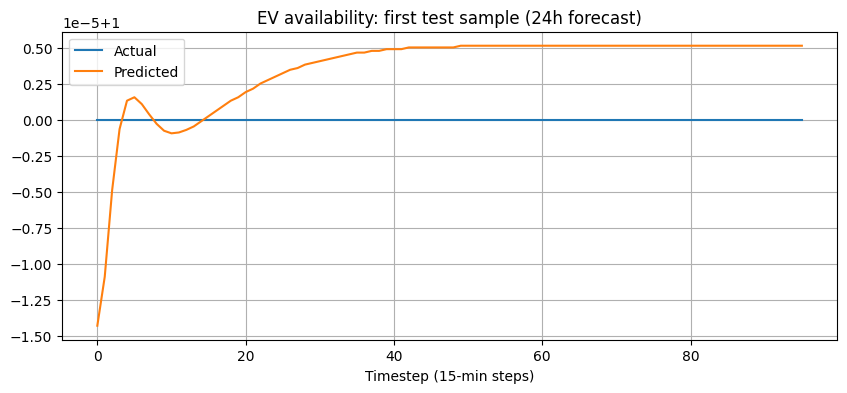

In [25]:
# Predict & inverse transform
y_ev_pred_scaled = ev_model.predict(X_ev_test)
y_ev_pred = ev_target_scaler.inverse_transform(y_ev_pred_scaled.reshape(-1,1)).reshape(-1, HORIZON)
y_ev_test_real = ev_target_scaler.inverse_transform(y_ev_test.reshape(-1,1)).reshape(-1, HORIZON)

evaluate_and_print(y_ev_test_real, y_ev_pred, label="EV (ev_count) - treated as numeric")
plot_first_sample(y_ev_test_real, y_ev_pred, HORIZON, title="EV availability: first test sample (24h forecast)")

In [26]:
# Save model + scalers
ev_model.save(os.path.join(out_dir, "ev_seq2seq_model.h5"))
joblib.dump(ev_input_scaler, os.path.join(out_dir, "ev_input_scaler.gz"))
joblib.dump(ev_target_scaler, os.path.join(out_dir, "ev_target_scaler.gz"))

print("All done. Models & scalers saved to:", out_dir)


All done. Models & scalers saved to: C:\Users\Administrator\v2g\step2_models
